# Part 1: Data Preparation and Exploration

In [163]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [164]:
# loading and understanding data 
df = pd.read_csv("C:\\Users\\DELL\\Desktop\\Assignments\\Timeseries\\exchange_rate.csv")

In [165]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [167]:
df.shape

(7588, 2)

In [168]:
# checking for null values 
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

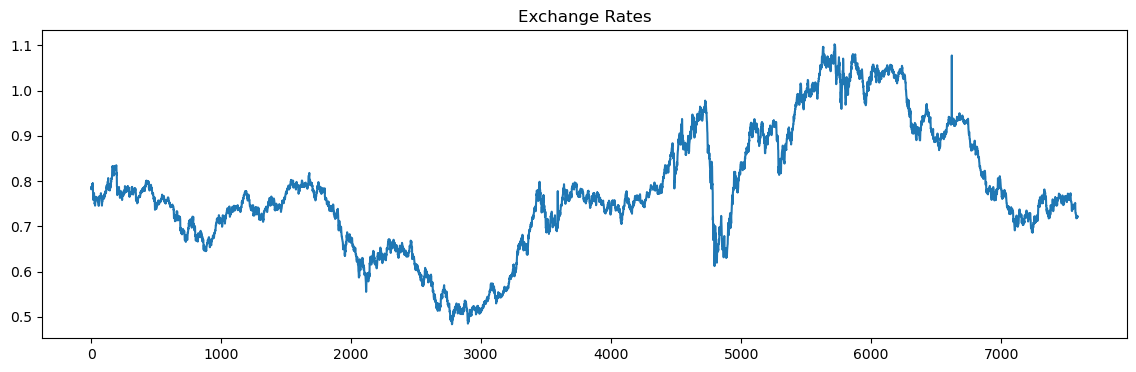

In [169]:
# Plot Time Series
plt.figure(figsize=(14, 4))
plt.plot(df['Ex_rate'])
plt.title('Exchange Rates')
plt.show()

# Part 2: ARIMA Model

In [171]:
#  ADF Test for Stationarity
from statsmodels.tsa.stattools import adfuller, acf, pacf
result = adfuller(df['Ex_rate'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")



ADF Statistic: -1.6649941807380735
p-value: 0.4492327353598314


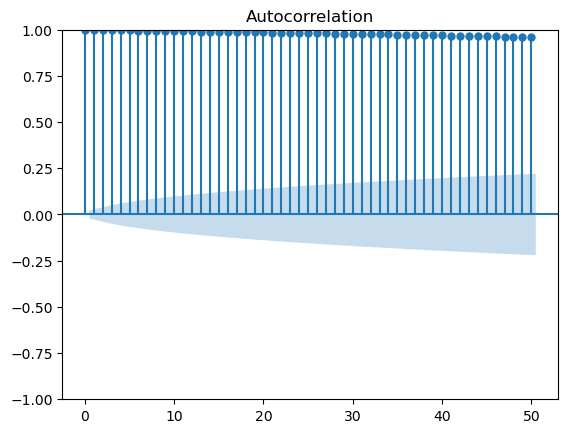

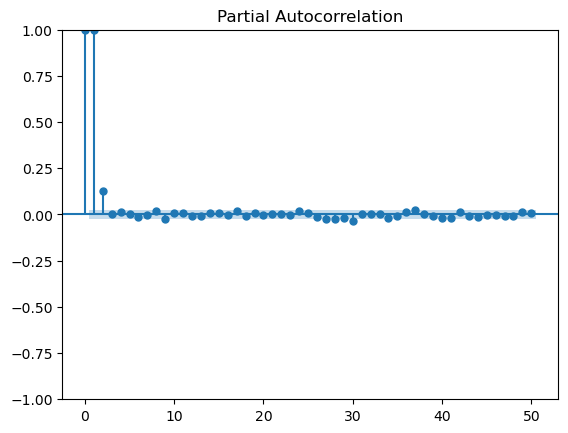

In [172]:
#  ACF and PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Ex_rate'].dropna(), lags=50)
plot_pacf(df['Ex_rate'].dropna(), lags=50)
plt.show()


In [173]:
# importing required libraries for implementation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [174]:
# Fit ARIMA Model
# Differencing if needed
d = 1  # Based on ADF and trend
model = ARIMA(df['Ex_rate'], order=(5, d, 2))
arima_result = model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(5, 1, 2)   Log Likelihood               28055.696
Date:                Wed, 25 Jun 2025   AIC                         -56095.392
Time:                        14:43:31   BIC                         -56039.919
Sample:                             0   HQIC                        -56076.354
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0651      0.664     -0.098      0.922      -1.367       1.237
ar.L2          0.0032      0.808      0.004      0.997      -1.581       1.587
ar.L3         -0.0166      0.107     -0.156      0.8

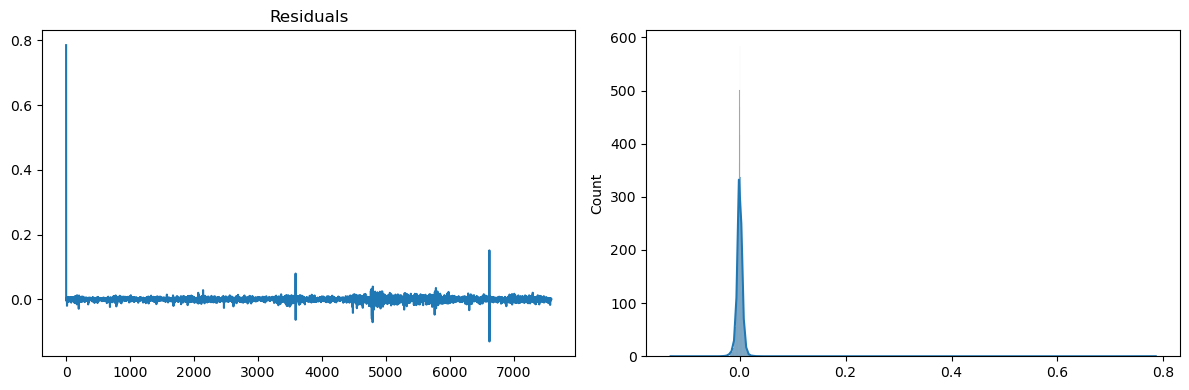

In [175]:
#  Residual Diagnostics
residuals = arima_result.resid

plt.figure(figsize=(12, 4))
plt.subplot(121)
residuals.plot(title="Residuals")
plt.subplot(122)
sns.histplot(residuals, kde=True)
plt.tight_layout()
plt.show()


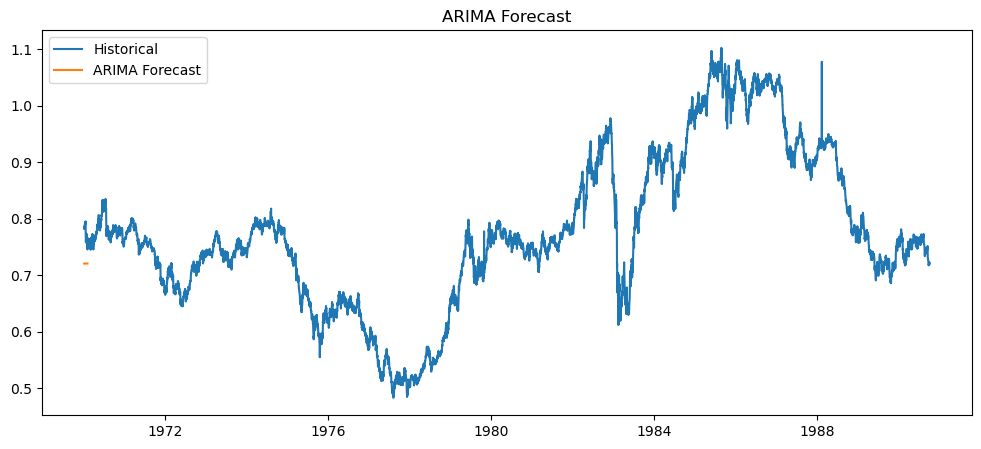

In [176]:
# Forecasting with ARIMA
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


#  Part 3: Exponential Smoothing

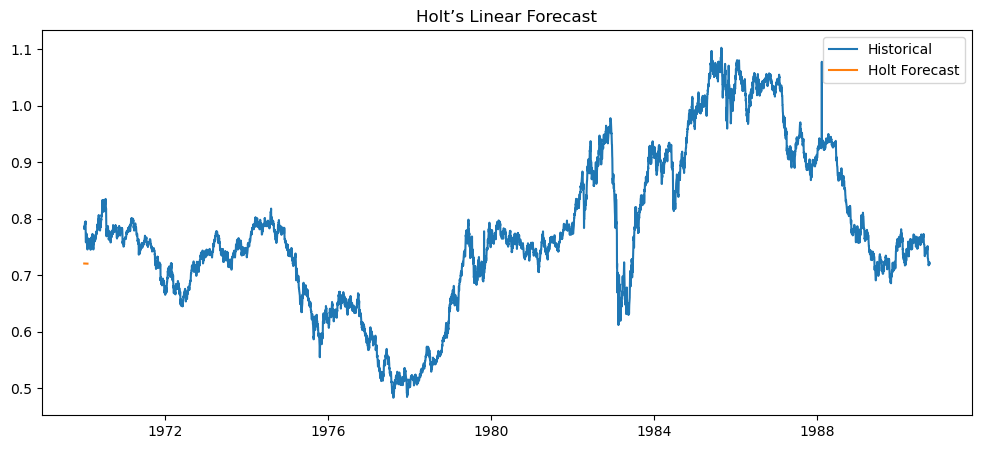

In [178]:
# Fit Holt-Winters Model
hw_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()
hw_forecast = hw_model.forecast(forecast_steps)

plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], hw_forecast, label='Holt Forecast')
plt.title('Holt’s Linear Forecast')
plt.legend()
plt.show()


# Part 4: Evaluation and Comparison

In [180]:
# Create Train-Test Split
train = df['Ex_rate'][:-30]
test = df['Ex_rate'][-30:]

In [181]:
# Refit models
arima_model = ARIMA(train, order=(5, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=30)

holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(30)

In [182]:
#  Error Metrics
def compute_metrics(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

compute_metrics(test, arima_forecast, "ARIMA")
compute_metrics(test, holt_forecast, "Holt-Winters")


ARIMA - MAE: 0.0135, RMSE: 0.0167, MAPE: 1.86%
Holt-Winters - MAE: 0.0134, RMSE: 0.0165, MAPE: 1.85%


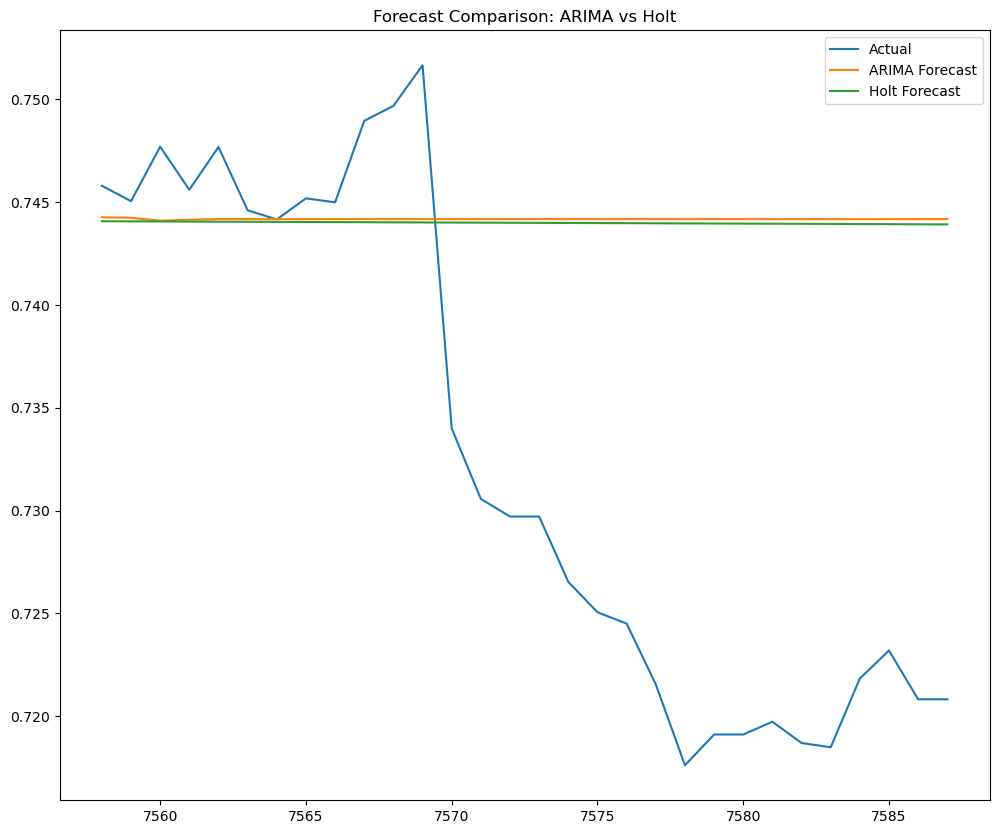

In [183]:
# Visual Forecast Comparison
plt.figure(figsize=(12, 10))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, holt_forecast, label='Holt Forecast')
plt.title('Forecast Comparison: ARIMA vs Holt')
plt.legend()
plt.show()


#  Summary of Insight's

## Forecasting Accuracy :

### ARIMA Model (Order: 5,1,2):
- **Mean Absolute Error (MAE):** 0.0135
- **Root Mean Squared Error (RMSE):** 0.0167
- **Mean Absolute Percentage Error (MAPE):** 1.86%

###  Holt-Winters (Holt’s Linear Trend) Model:
- **Mean Absolute Error (MAE):** 0.0134
- **Root Mean Squared Error (RMSE):** 0.0165
- **Mean Absolute Percentage Error (MAPE):** 1.85%

## Performance Summary:
- Both **ARIMA** and **Holt-Winters** models performed **very similarly** with **minor differences** in error metrics.
- **Holt-Winters** slightly outperformed ARIMA in this specific test set by a **small margin in all three error metrics**.
- However, both models are **suitable and acceptable** for short-term forecasting of exchange rates for this dataset.

## Final Insight:
Given the **nearly equal performance**, model choice can depend on:
- **ARIMA:** If fine-tuning and capturing autocorrelations and lags is important.
- **Holt-Winters:** If simplicity and faster training are preferred.
